In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn


In [2]:
# Load yield data
df_yield = pd.read_csv('dataset/yield.csv')
df_yield = df_yield.rename(index=str, columns={"Value": "hg/ha_yield"})
df_yield = df_yield.drop(['Year Code','Element Code','Element','Year Code','Area Code','Domain Code','Domain','Unit','Item Code'], axis=1)


In [3]:
#load and clean Rainfall
df_rain = pd.read_csv('dataset/rainfall.csv')
df_rain = df_rain.rename(columns={" Area": 'Area'})
df_rain['average_rain_fall_mm_per_year'] = df_rain['average_rain_fall_mm_per_year'].apply(pd.to_numeric, downcast='float', errors='coerce')
df_rain = df_rain.dropna()
df_rain.head()

Area  Year  average_rain_fall_mm_per_year
0  Afghanistan  1985                          327.0
1  Afghanistan  1986                          327.0
2  Afghanistan  1987                          327.0
3  Afghanistan  1989                          327.0
4  Afghanistan  1990                          327.0

In [4]:
yield_df = pd.merge(df_yield, df_rain, on=['Year', 'Area'])


In [5]:
df_pes = pd.read_csv('dataset/pesticides.csv')
df_pes = df_pes.rename(columns={"Value": "pesticides_tonnes"})
df_pes = df_pes.drop(['Element', 'Domain', 'Unit', 'Item'], axis=1)
yield_df = pd.merge(yield_df, df_pes, on=['Year', 'Area'])


In [6]:
avg_temp = pd.read_csv('dataset/temp.csv')
avg_temp = avg_temp.rename(columns={"year": "Year", "country": 'Area'})
yield_df = pd.merge(yield_df, avg_temp, on=['Area', 'Year'])


In [7]:
yield_df_onehot = pd.get_dummies(yield_df, columns=['Area', "Item"], prefix=['Country', "Item"])


In [8]:
# Extract feature names from the DataFrame before scaling
feature_names = yield_df_onehot.loc[:, yield_df_onehot.columns != 'hg/ha_yield'].drop(['Year'], axis=1).columns

# Prepare features and label for modeling
features = yield_df_onehot.loc[:, yield_df_onehot.columns != 'hg/ha_yield']
label = yield_df['hg/ha_yield']

# Drop 'Year' column and scale features
features = features.drop(['Year'], axis=1)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(features_scaled, label, test_size=0.3, random_state=42)


In [9]:
# Define a function to compare models
def compare_models(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_data, train_labels)
    y_pred = fit.predict(test_data)
    r2 = r2_score(test_labels, y_pred)
    return [model_name, r2]

# Initialize models
models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
    RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(gamma='auto'),
    DecisionTreeRegressor()
]

# Compare models
model_train = list(map(compare_models, models))
print(*model_train, sep="\n")


['GradientBoostingRegressor', 0.8965768919264416]
['RandomForestRegressor', 0.6842532317855172]
['SVR', -0.20353376480360752]
['DecisionTreeRegressor', 0.9602373113083807]


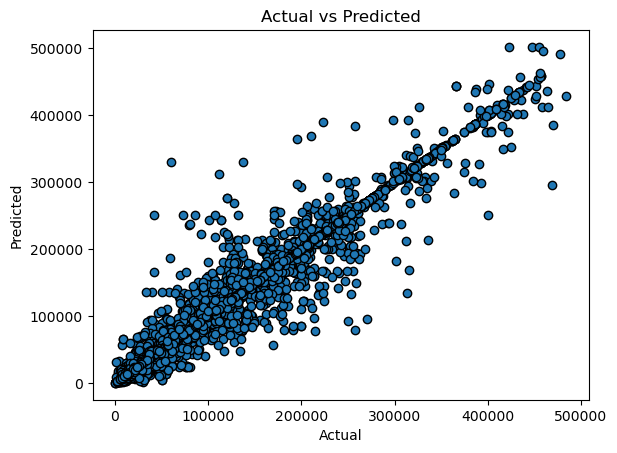

In [18]:
# Define and train the model
clf = DecisionTreeRegressor()
model = clf.fit(train_data, train_labels)

# Ensure test_data has the same columns as train_data
test_data_df = pd.DataFrame(test_data, columns=feature_names)

# Extract country and item from one-hot encoded columns
cntry = test_data_df[[col for col in test_data_df.columns if 'Country' in col]].stack()[test_data_df[[col for col in test_data_df.columns if 'Country' in col]].stack() > 0]
cntrylist = list(pd.DataFrame(cntry).index.get_level_values(1))
countries = [i.split("_")[1] for i in cntrylist]

itm = test_data_df[[col for col in test_data_df.columns if 'Item' in col]].stack()[test_data_df[[col for col in test_data_df.columns if 'Item' in col]].stack() > 0]
itmlist = list(pd.DataFrame(itm).index.get_level_values(1))
items = [i.split("_")[1] for i in itmlist]

test_data_df.drop([col for col in test_data_df.columns if 'Item' in col], axis=1, inplace=True)
test_data_df.drop([col for col in test_data_df.columns if 'Country' in col], axis=1, inplace=True)
test_data_df['Country'] = countries
test_data_df['Item'] = items

# Predict and compare actual vs. predicted yields
test_data_df["yield_predicted"] = model.predict(test_data)
test_data_df["yield_actual"] = pd.DataFrame(test_labels).reset_index(drop=True)

# Visualize actual vs predicted
fig, ax = plt.subplots()
ax.scatter(test_data_df["yield_actual"], test_data_df["yield_predicted"], edgecolors=(0, 0, 0))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()


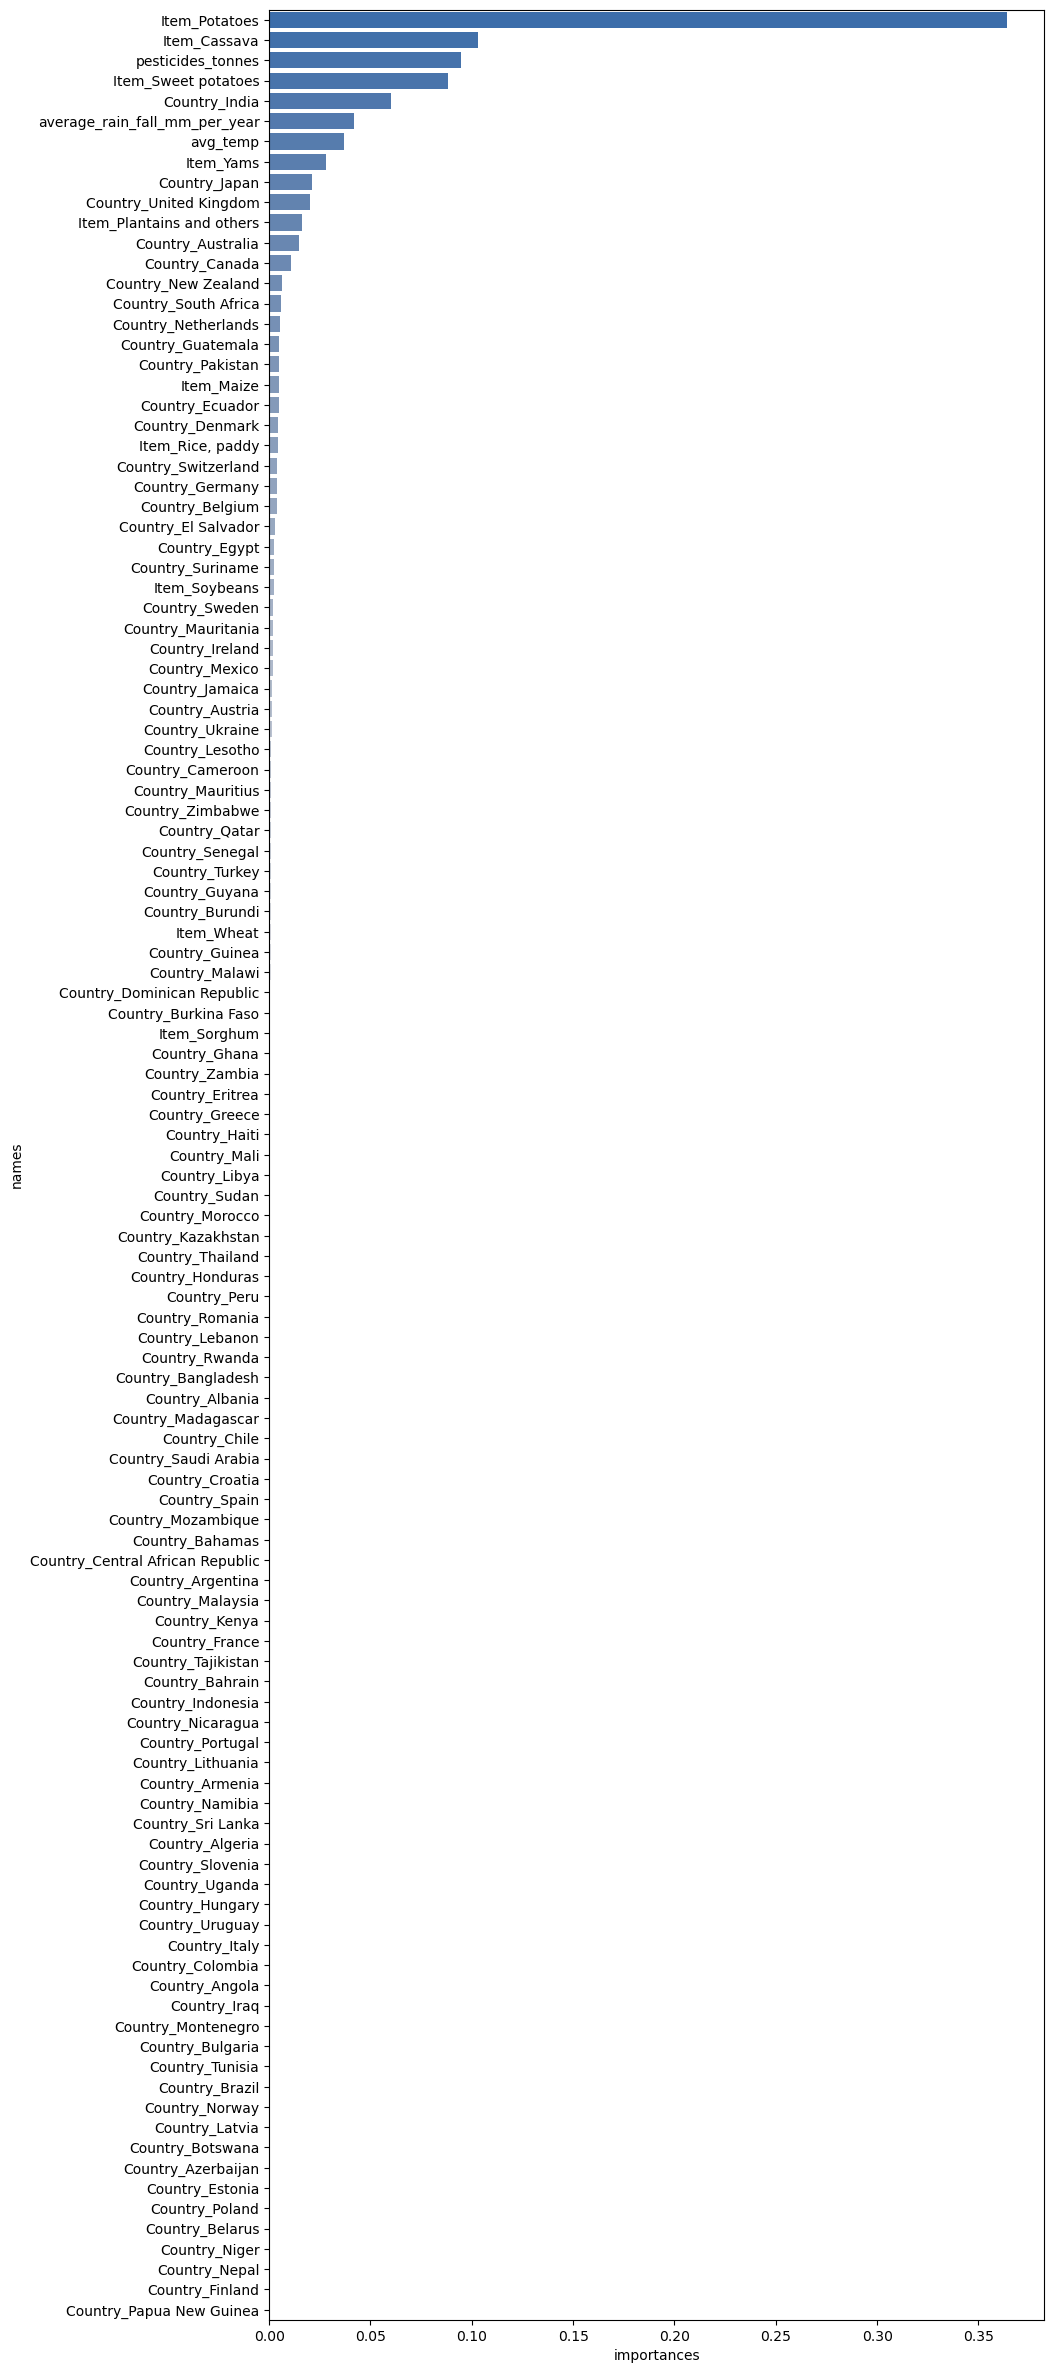

In [19]:
# Feature importance visualization (if applicable)
if hasattr(model, 'feature_importances_'):
    varimp = {'importances': model.feature_importances_, 'names': feature_names}

    fig, ax = plt.subplots(figsize=(10, 30))
    df = pd.DataFrame.from_dict(varimp)
    df.sort_values(ascending=False, by=["importances"], inplace=True)
    df.dropna(inplace=True)
    sns.barplot(x="importances", y="names", palette="vlag", data=df, orient="h", ax=ax)


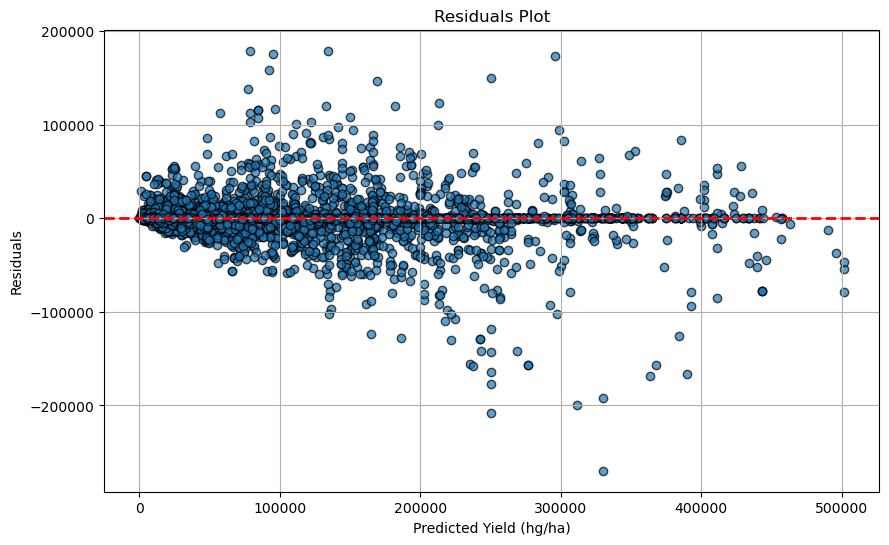

In [20]:
# Calculate residuals
test_data_df["residuals"] = test_data_df["yield_actual"] - test_data_df["yield_predicted"]

# Plot residuals
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(test_data_df["yield_predicted"], test_data_df["residuals"], edgecolors='k', alpha=0.7)
ax.axhline(0, color='r', linestyle='--', linewidth=2)  # Line at zero residual
ax.set_xlabel('Predicted Yield (hg/ha)')
ax.set_ylabel('Residuals')
ax.set_title('Residuals Plot')
plt.grid(True)
plt.show()


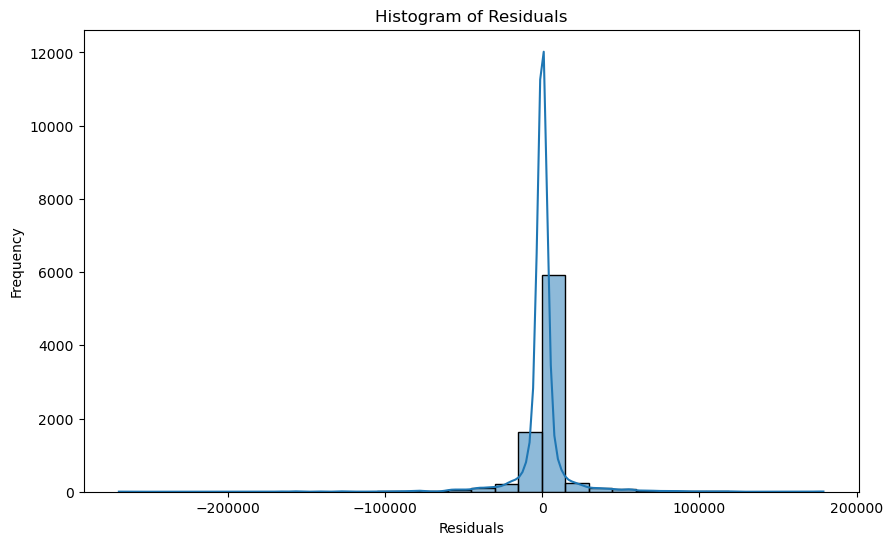

In [21]:
# Plot histogram of residuals
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(test_data_df["residuals"], kde=True, bins=30, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
plt.show()


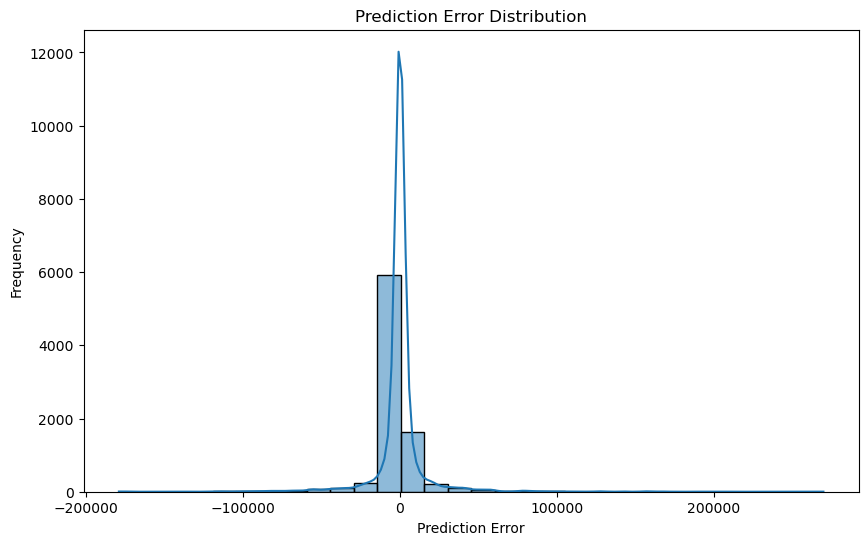

In [22]:
# Calculate prediction errors
test_data_df["error"] = test_data_df["yield_predicted"] - test_data_df["yield_actual"]

# Plot prediction error distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(test_data_df["error"], kde=True, bins=30, ax=ax)
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Frequency')
ax.set_title('Prediction Error Distribution')
plt.show()


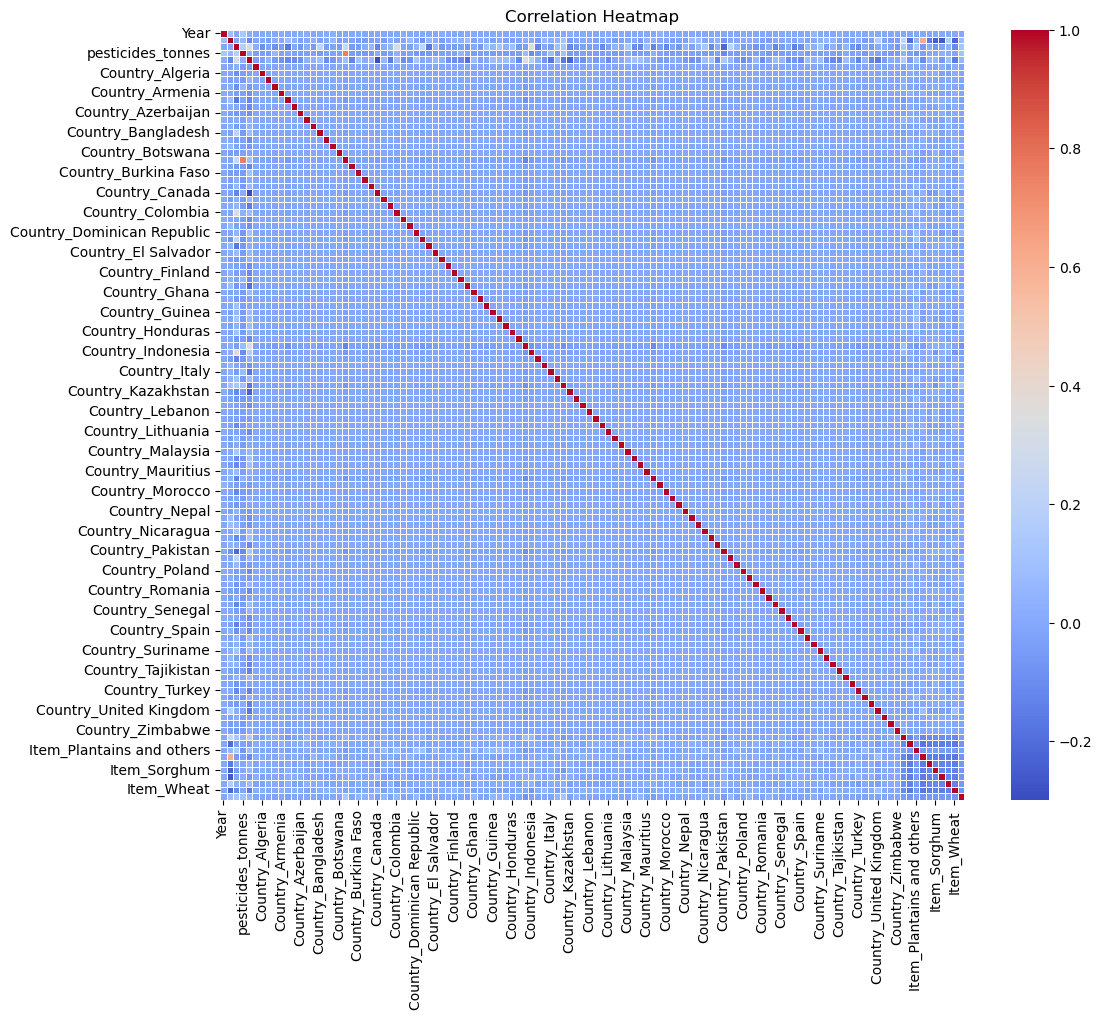

In [23]:
# Compute correlation matrix
corr_data = yield_df_onehot.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_data, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5, ax=ax)
ax.set_title('Correlation Heatmap')
plt.show()


C:\Users\ntigy\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


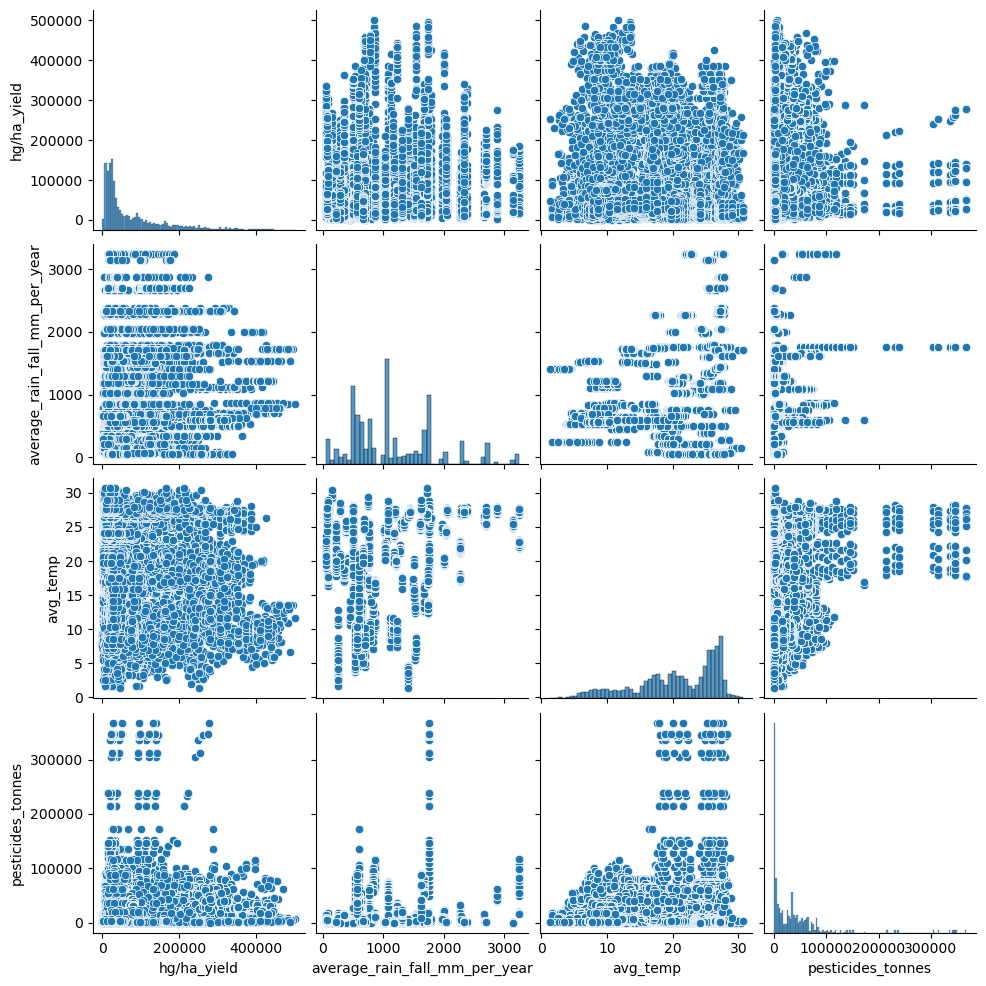

In [24]:
# Pair plot (for a subset of features for clarity)
subset = yield_df_onehot[['hg/ha_yield', 'average_rain_fall_mm_per_year', 'avg_temp', 'pesticides_tonnes']]
sns.pairplot(subset)
plt.show()


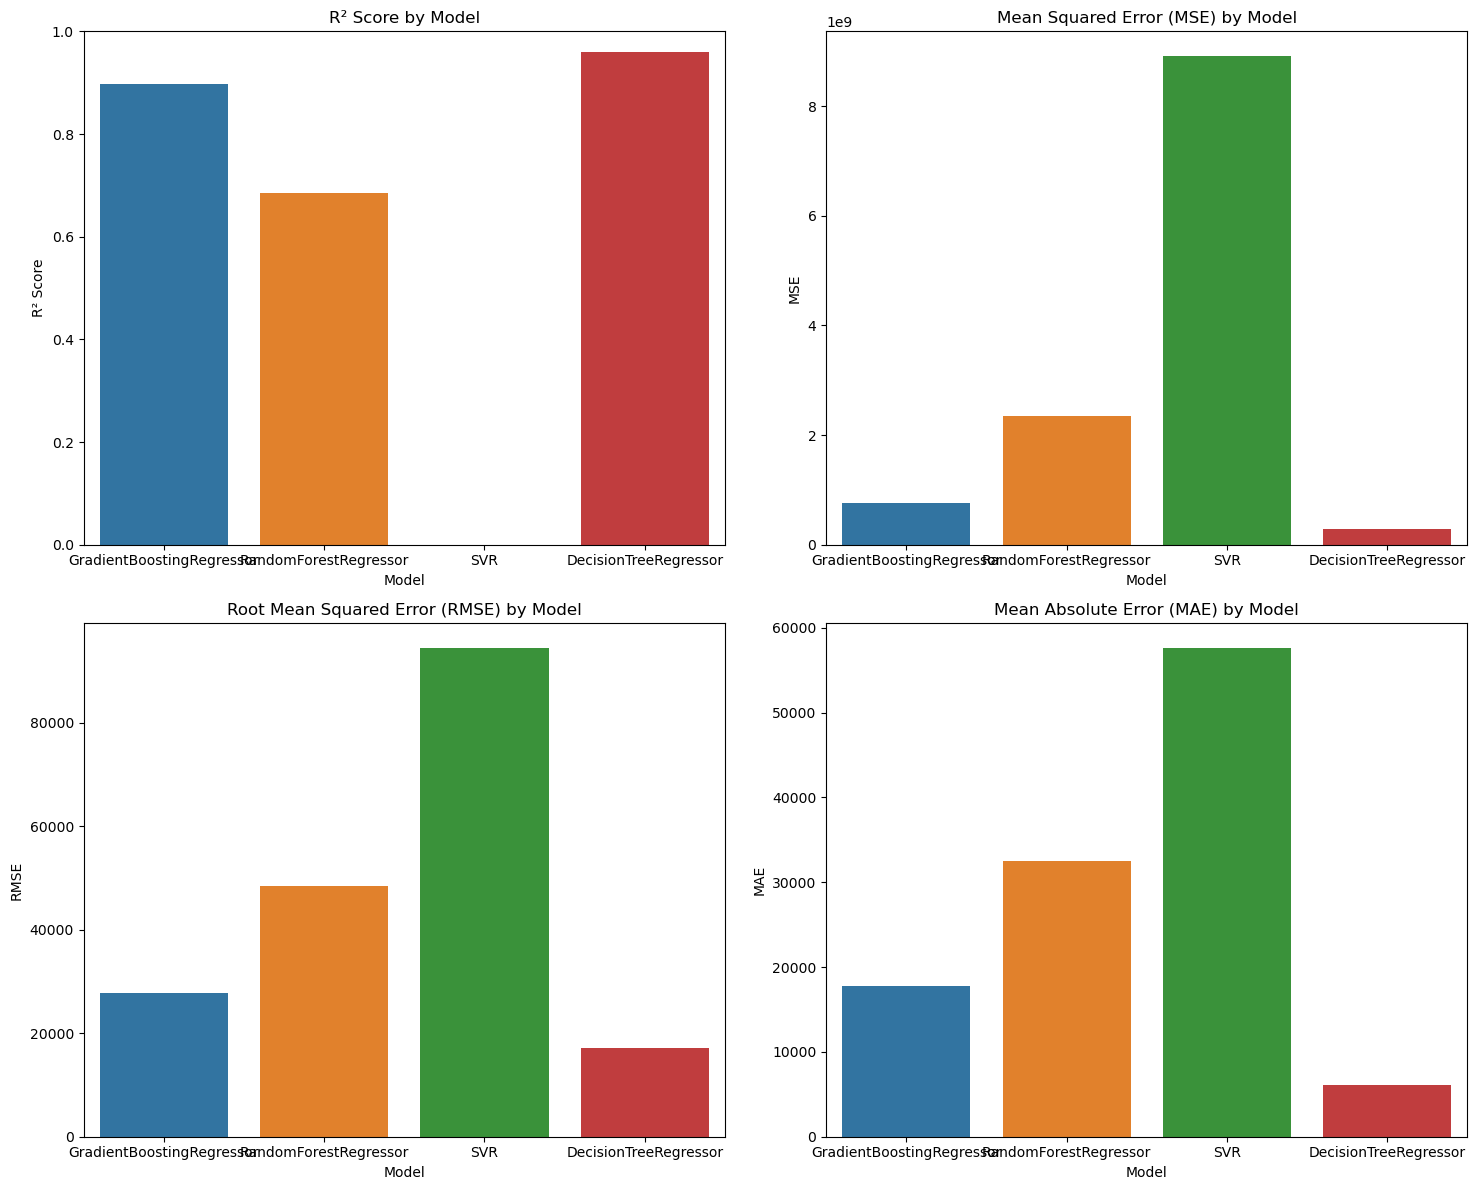

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to compute evaluation metrics
def evaluate_model(model):
    model_name = model.__class__.__name__
    y_pred = model.predict(test_data)
    
    r2 = r2_score(test_labels, y_pred)
    mse = mean_squared_error(test_labels, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_labels, y_pred)
    
    return {
        'Model': model_name,
        'R² Score': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

# Evaluate all models
evaluation_results = list(map(evaluate_model, models))

# Convert to DataFrame for easier plotting
eval_df = pd.DataFrame(evaluation_results)

# Plot R² Score, MSE, RMSE, and MAE
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# R² Score
sns.barplot(x='Model', y='R² Score', data=eval_df, ax=axs[0, 0])
axs[0, 0].set_title('R² Score by Model')
axs[0, 0].set_ylim(0, 1)

# MSE
sns.barplot(x='Model', y='MSE', data=eval_df, ax=axs[0, 1])
axs[0, 1].set_title('Mean Squared Error (MSE) by Model')

# RMSE
sns.barplot(x='Model', y='RMSE', data=eval_df, ax=axs[1, 0])
axs[1, 0].set_title('Root Mean Squared Error (RMSE) by Model')

# MAE
sns.barplot(x='Model', y='MAE', data=eval_df, ax=axs[1, 1])
axs[1, 1].set_title('Mean Absolute Error (MAE) by Model')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


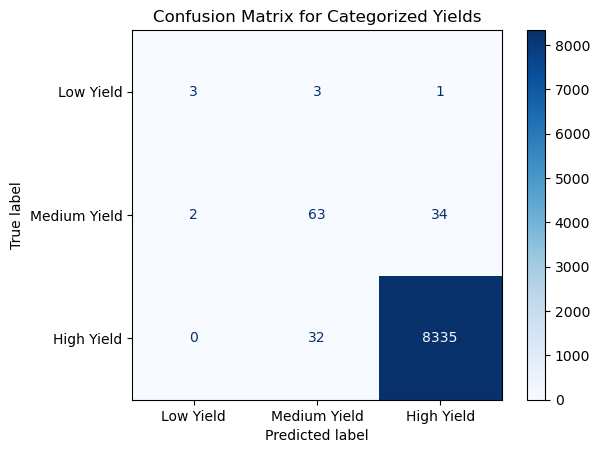

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Categorize the actual and predicted yields
def categorize_yield(y):
    if y < 1000:
        return 'Low Yield'
    elif y < 5000:
        return 'Medium Yield'
    else:
        return 'High Yield'

# Apply categorization to both actual and predicted yields
test_data_df['yield_category_actual'] = test_data_df['yield_actual'].apply(categorize_yield)
test_data_df['yield_category_predicted'] = test_data_df['yield_predicted'].apply(categorize_yield)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_data_df['yield_category_actual'], test_data_df['yield_category_predicted'], labels=['Low Yield', 'Medium Yield', 'High Yield'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Yield', 'Medium Yield', 'High Yield'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Categorized Yields')
plt.show()


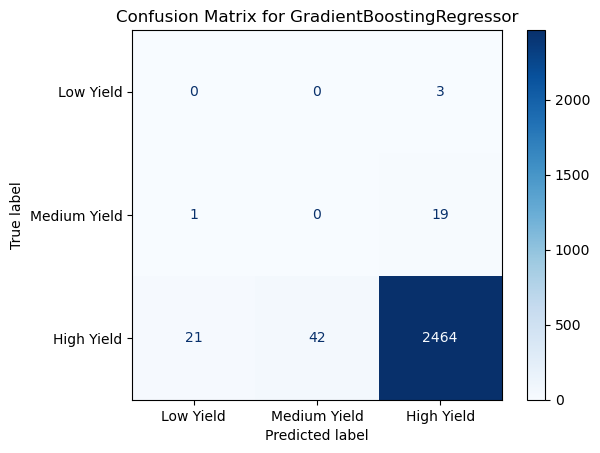

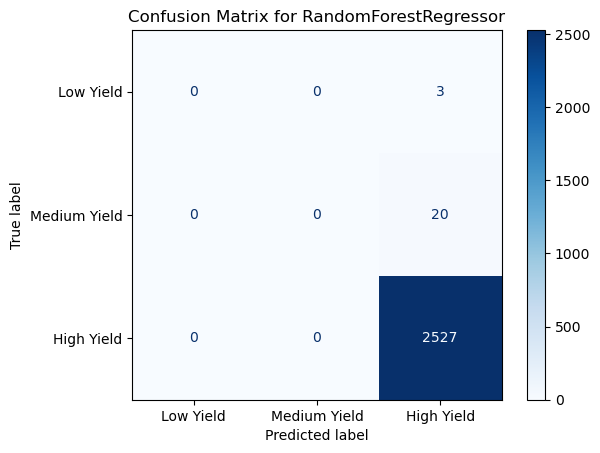

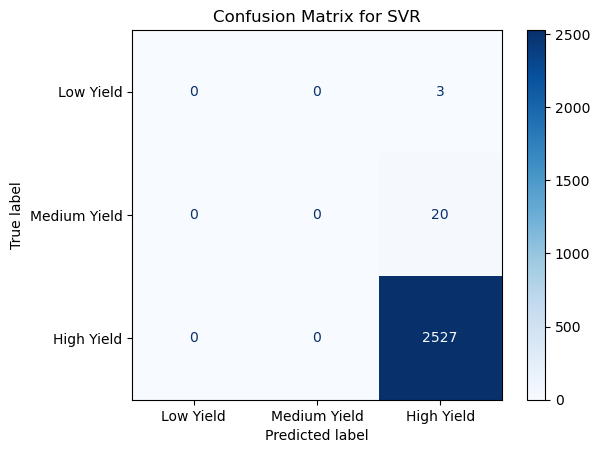

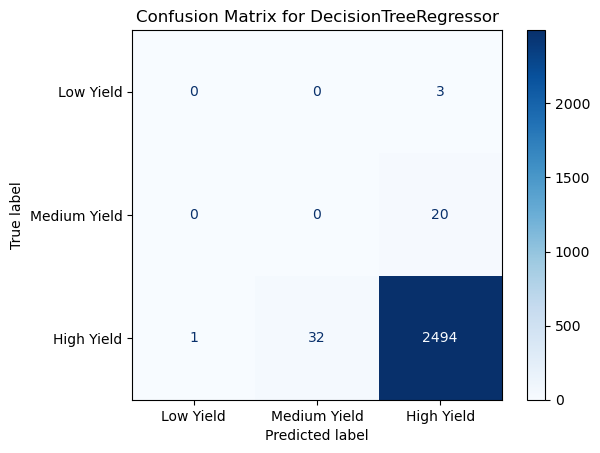

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to categorize yields
def categorize_yield(y):
    if y < 1000:
        return 'Low Yield'
    elif y < 5000:
        return 'Medium Yield'
    else:
        return 'High Yield'

# Function to plot confusion matrix for a given model
def plot_confusion_matrix_for_model(model):
    model_name = model.__class__.__name__
    
    # Predict the yields
    y_pred = model.predict(test_data)
    
    # Categorize the actual and predicted yields
    test_data_df['yield_category_actual'] = test_labels.apply(categorize_yield).astype(str)
    test_data_df['yield_category_predicted'] = pd.Series(y_pred).apply(categorize_yield).astype(str)
    
    # Ensure no null values are present
    test_data_df.dropna(subset=['yield_category_actual', 'yield_category_predicted'], inplace=True)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_data_df['yield_category_actual'], test_data_df['yield_category_predicted'], labels=['Low Yield', 'Medium Yield', 'High Yield'])
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Yield', 'Medium Yield', 'High Yield'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrix for each model
for model in models:
    plot_confusion_matrix_for_model(model)


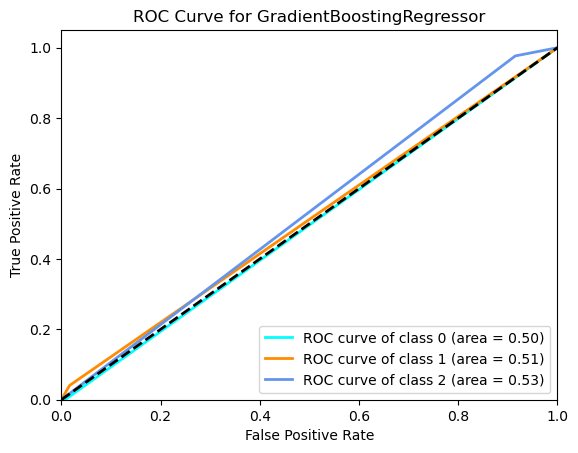

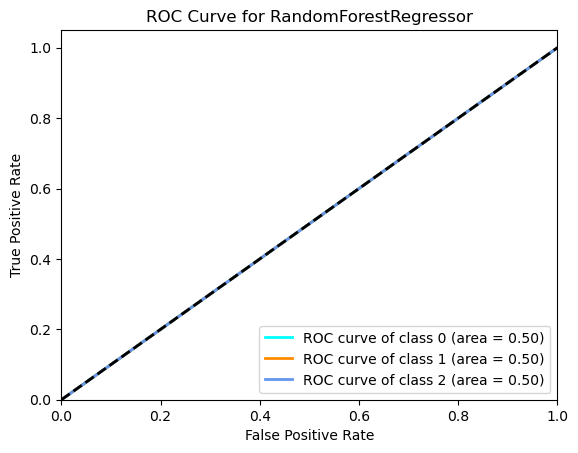

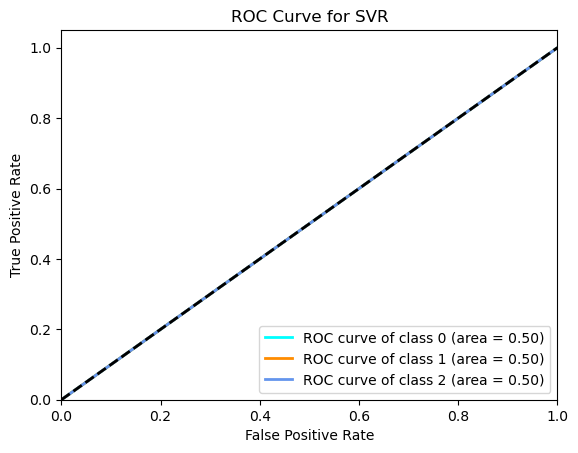

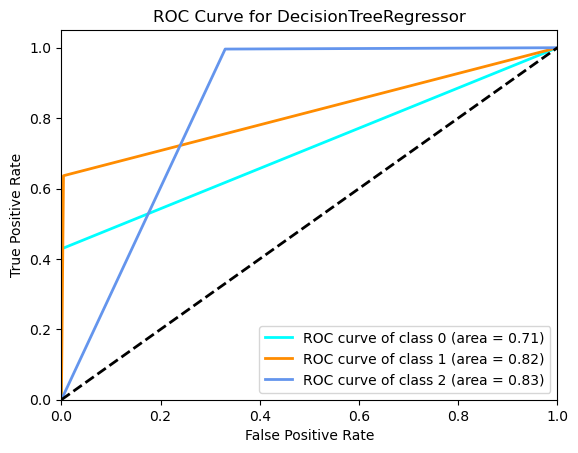

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output classes
test_labels_categorized = test_labels.apply(categorize_yield).astype(str)
y_test_bin = label_binarize(test_labels_categorized, classes=['Low Yield', 'Medium Yield', 'High Yield'])
n_classes = y_test_bin.shape[1]

# Function to compute ROC AUC for a model
def compute_roc_auc(model):
    y_pred = model.predict(test_data)
    y_pred_categorized = pd.Series(y_pred).apply(categorize_yield).astype(str)
    y_pred_bin = label_binarize(y_pred_categorized, classes=['Low Yield', 'Medium Yield', 'High Yield'])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc="lower right")
    plt.show()

# Compute and plot ROC AUC for each model
for model in models:
    compute_roc_auc(model)


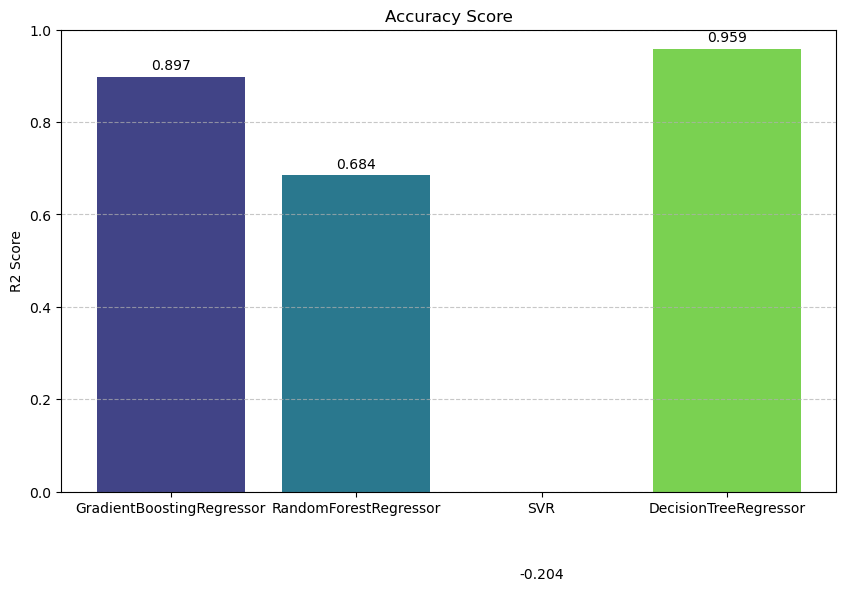

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to compare models
def compare_models(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_data, train_labels)
    y_pred = fit.predict(test_data)
    r2 = r2_score(test_labels, y_pred)
    return [model_name, r2]

# Initialize models
models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
    RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(gamma='auto'),
    DecisionTreeRegressor()
]

# Compare models
model_train = list(map(compare_models, models))

# Extract model names and R2 scores for plotting
model_names = [model[0] for model in model_train]
r2_scores = [model[1] for model in model_train]

# Set up the color palette
colors = sns.color_palette("viridis", len(models))

# Plot the R2 scores
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_scores, color=colors)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

# Customize the plot
plt.ylabel('R2 Score')
plt.title('Accuracy Score')
plt.ylim(0, 1)  # Set the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [24]:
# Save the trained model and scaler
import pickle

# Save model
filename = 'model/model.sav'
pickle.dump(model, open(filename, 'wb'))

# Save scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))


In [26]:
def predict_yield(country, item, year, avg_rainfall, avg_temp, pesticides_tonnes):
    # Create a DataFrame for the input data
    input_data = pd.DataFrame({
        'Country': [country],
        'Item': [item],
        'Year': [year],  # Include year if it was used as a feature
        'average_rain_fall_mm_per_year': [avg_rainfall],
        'avg_temp': [avg_temp],
        'pesticides_tonnes': [pesticides_tonnes]
    })
    
    # One-hot encode 'Country' and 'Item'
    input_data = pd.get_dummies(input_data, columns=['Country', 'Item'])
    
    # Create a DataFrame with all possible columns
    all_columns = yield_df_onehot.columns
    input_data = input_data.reindex(columns=all_columns, fill_value=0)
    
    # Drop 'Year' column if it exists (ensure no target column is included)
    input_data = input_data.drop(['Year'], axis=1, errors='ignore')
    input_data = input_data.drop(['hg/ha_yield'], axis=1, errors='ignore')
    
    # Apply the same scaling used during training
    try:
        input_data_scaled = scaler.transform(input_data)
    except ValueError as e:
        print(f"Error during scaling: {e}")
        return None
    
    # Predict the yield
    try:
        yield_predicted = model.predict(input_data_scaled)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None
    
    return yield_predicted[0]
